# Use of Affective Computing to Improve Social and Emotional Functioning of Children with Autism

## Introduction

### Background
The development and application of affective computing have been burgeoning in recent years, with a wide array of applications in healthcare, education, and human-computer interaction. However, there is a considerable lack of research specifically targeting the unique emotional and sensory experiences of children with Autism Spectrum Disorder (ASD). These gaps present both a challenge and an opportunity to contribute meaningful insights that could have transformative effects on the lives of these children and their caregivers.

### Objectives
The present study aims to bridge these research gaps by devising a comprehensive framework focusing on the affective computing capabilities targeted at children with ASD. The study seeks to answer several key questions that have been largely overlooked in the existing literature:

1. **Efficacy and Accuracy**: We aim to explore the feasibility of constructing an AI model that can accurately interpret the emotions of children with ASD. This is a largely unexplored area that could offer groundbreaking insights.

2. **Consistency Across Emotional States**: This study will also examine the model's ability to consistently detect a range of emotions, thereby adding depth to typically one-dimensional approaches.

3. **Comparative Analysis**: A rigorous comparative analysis will be conducted to identify if there are statistically significant differences in model performance when applied to children with ASD versus neurotypical children.

4. **Intra-Group Variation**: The study will investigate whether children with ASD express their emotions in a consistent manner or if variations occur, thus contributing to the limited literature focused on the personalization aspect of technology.

5. **Contextual Understanding**: We will explore how children with ASD conceptualize and share emotions and sensory experiences during their daily lives.

6. **Technological Response**: The final objective of this study is to understand how children with ASD interact with digital technologies, especially in the context of their social, emotional, and sensory experiences.

### Methodology
To achieve these objectives, we will be implementing a Convolutional Neural Network (CNN) that classifies the emotions of children with ASD. The model will be trained and validated on an image dataset sourced from Kaggle, which can be accessed through the following [link](https://www.kaggle.com/datasets/fatmamtalaat/autistic-children-emotions-dr-fatma-m-talaat/data).

### Contributions
By meticulously investigating these aspects, this study aims to make a significant contribution to both the affective computing and autism research communities. The findings promise to offer robust and actionable insights that are not only theoretically enriching but also practically relevant for educators, healthcare providers, and technologists.

---

#### **The project consists of the following sections:**
* [Section 1](#section1): Importing and Preprocessing the Dataset
* [Section 2](#section2): Exploratory Data Analysis (EDA)
* [Section 3](#section3): Creating and evaluating a CNN to Classify CT kidney images

<a id='section1'></a>
## Section 1: Importing and Preprocessing the Dataset

In [ ]:
# install kaggle package
!pip install kaggle -q

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# fill in my user name and key from creating the kaggle account and API token file
import json
kaggle_username = ""
kaggle_key = ""

# save API token to the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [ ]:
# download the dataset, it will be in a .zip file so I'll unzip it as well.
!kaggle datasets download --force -d fatmamtalaat/autistic-children-emotions-dr-fatma-m-talaat
# unzip the file
!unzip -o -q autistic-children-emotions-dr-fatma-m-talaat.zip

 93% 22.0M/23.6M [00:02<00:00, 15.0MB/s]
100% 23.6M/23.6M [00:02<00:00, 10.4MB/s]


In [ ]:
# import necessary packages and frameworks
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import load_model, Sequential, Model
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
# ignore some irrelevant tensorflow warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR);

In [ ]:
# Define the base directories for train and test datasets
base_train_dir = "./Autistic Children Emotions - Dr. Fatma M. Talaat/Train"
base_test_dir = "./Autistic Children Emotions - Dr. Fatma M. Talaat/Test"

# Initialize empty lists to store the file paths and labels
train_file_paths = []
train_labels = []

test_file_paths = []
test_labels = []

# Walk through the train directory to get the file paths and labels
for emotion in os.listdir(base_train_dir):
    emotion_dir = os.path.join(base_train_dir, emotion)
    if os.path.isdir(emotion_dir):
        for filename in os.listdir(emotion_dir):
            if filename.endswith((".png", ".jpg", ".jpeg")):  # Add or remove file extensions as needed
                file_path = os.path.join(emotion_dir, filename)
                train_file_paths.append(file_path)
                train_labels.append(emotion)

# Walk through the test directory to get the file paths and labels
for emotion in os.listdir(base_test_dir):
    emotion_dir = os.path.join(base_test_dir, emotion)
    if os.path.isdir(emotion_dir):
        for filename in os.listdir(emotion_dir):
            if filename.endswith((".png", ".jpg", ".jpeg")):  # Add or remove file extensions as needed
                file_path = os.path.join(emotion_dir, filename)
                test_file_paths.append(file_path)
                test_labels.append(emotion)

# Create the DataFrames
train_df = pd.DataFrame({
    'image_path': train_file_paths,
    'label': train_labels
})

test_df = pd.DataFrame({
    'image_path': test_file_paths,
    'label': test_labels
})

# Display the first few rows of the DataFrames
print(train_df.head())
print(test_df.head())


                                          image_path  label
0  ./Autistic Children Emotions - Dr. Fatma M. Ta...  anger
1  ./Autistic Children Emotions - Dr. Fatma M. Ta...  anger
2  ./Autistic Children Emotions - Dr. Fatma M. Ta...  anger
3  ./Autistic Children Emotions - Dr. Fatma M. Ta...  anger
4  ./Autistic Children Emotions - Dr. Fatma M. Ta...  anger
                                          image_path    label
0  ./Autistic Children Emotions - Dr. Fatma M. Ta...    anger
1  ./Autistic Children Emotions - Dr. Fatma M. Ta...    anger
2  ./Autistic Children Emotions - Dr. Fatma M. Ta...    anger
3  ./Autistic Children Emotions - Dr. Fatma M. Ta...  sadness
4  ./Autistic Children Emotions - Dr. Fatma M. Ta...  sadness


In [ ]:
# print number of images in each class
train_df.label.value_counts()

joy         350
sadness     200
anger        67
surprise     63
Natural      48
fear         30
Name: label, dtype: int64

In [ ]:
# print number of images in each class
test_df.label.value_counts()

joy         42
sadness     14
Natural      7
surprise     6
anger        3
fear         3
Name: label, dtype: int64

In [ ]:
# Define data augmentation options for training
generator = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,  # reduced rotation
    width_shift_range=0.1,  # reduced shift
    height_shift_range=0.1,  # reduced shift
    shear_range=0.1,  # reduced shear
    zoom_range=0.1,  # reduced zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the training generator
train_generator = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Create the test generator (without data augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 758 validated image filenames belonging to 6 classes.
Found 75 validated image filenames belonging to 6 classes.


<a id='section2'></a>
## Section 2: Exploratory Data Analysis (EDA)


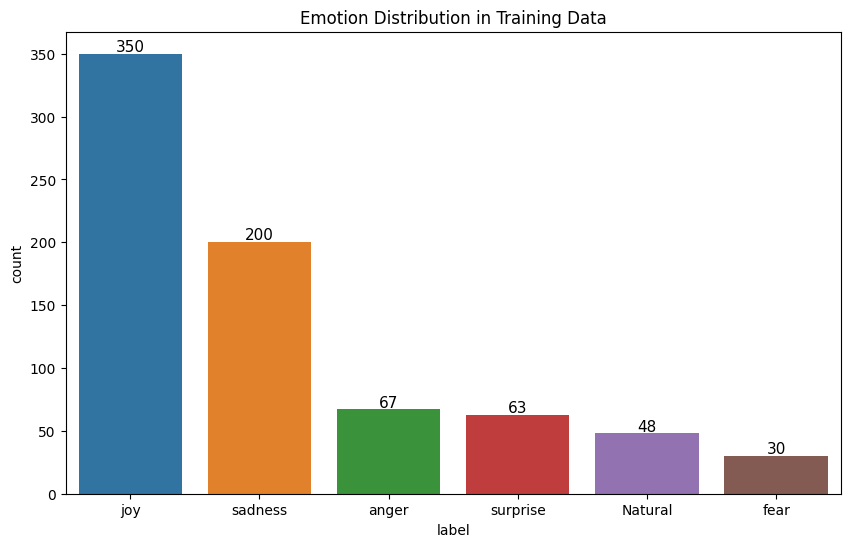

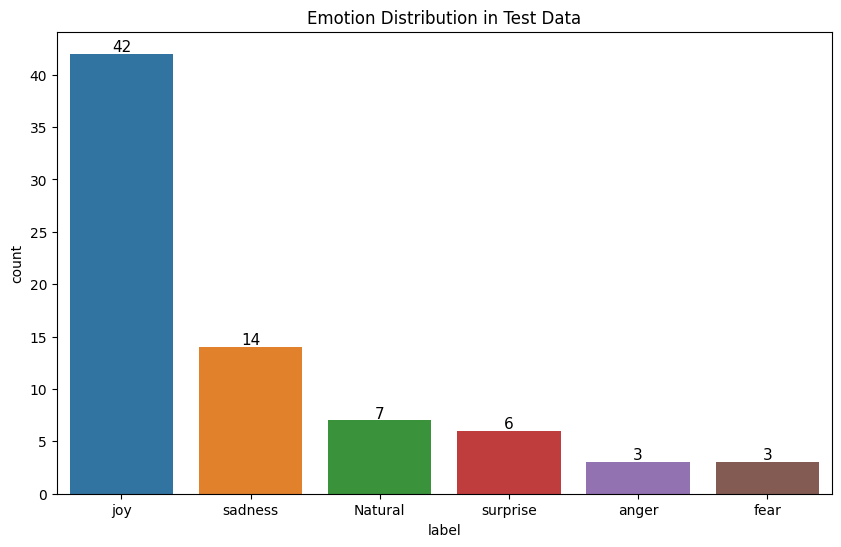

In [ ]:
# Function to plot with count annotations
def plot_with_count(df, column, title):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=column, data=df, order=df[column].value_counts().index)
    plt.title(title)

    # Add counts on each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

# Extract file extensions in train and test data
train_df['extension'] = train_df['image_path'].apply(lambda x: x.split('.')[-1])
test_df['extension'] = test_df['image_path'].apply(lambda x: x.split('.')[-1])

# Emotion Distribution in Training Data
plot_with_count(train_df, 'label', 'Emotion Distribution in Training Data')

# Emotion Distribution in Test Data
plot_with_count(test_df, 'label', 'Emotion Distribution in Test Data')



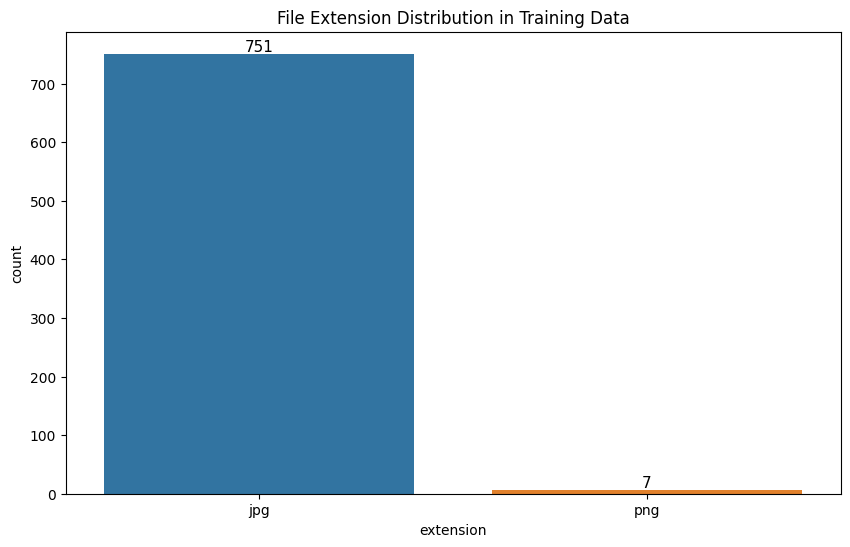

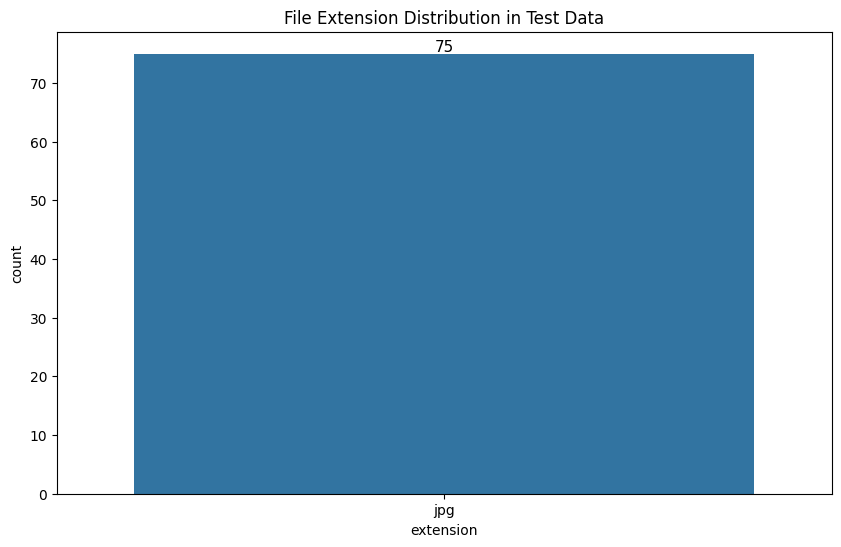

In [ ]:
# File Extension Distribution in Training Data
plot_with_count(train_df, 'extension', 'File Extension Distribution in Training Data')

# File Extension Distribution in Test Data
plot_with_count(test_df, 'extension', 'File Extension Distribution in Test Data')

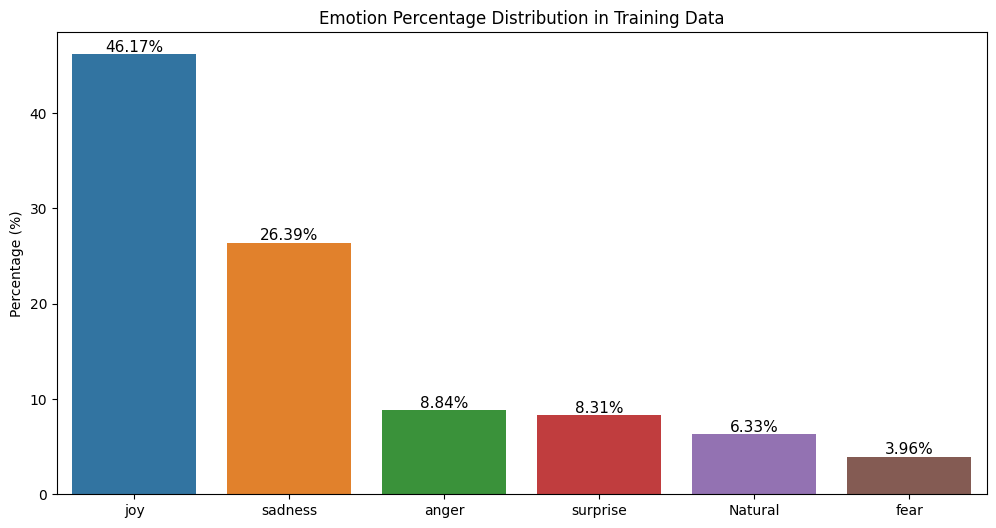

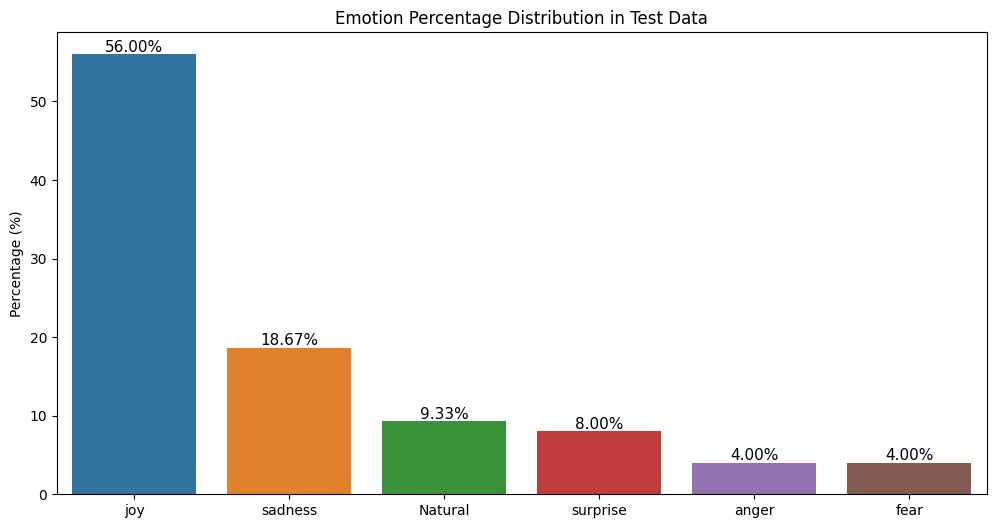

In [ ]:
# Function to plot percentage distribution
def plot_percentage_distribution(df_percentage, title):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=df_percentage.index, y=df_percentage.values)

    plt.title(title)
    plt.ylabel('Percentage (%)')

    # Add percentage annotations on each bar
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{df_percentage.values[i]:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

# Calculate and print percentage distribution of emotions in training and test data
train_percentage = train_df['label'].value_counts(normalize=True) * 100
test_percentage = test_df['label'].value_counts(normalize=True) * 100


# Plotting percentage distribution for training and test data
plot_percentage_distribution(train_percentage, 'Emotion Percentage Distribution in Training Data')
plot_percentage_distribution(test_percentage, 'Emotion Percentage Distribution in Test Data')

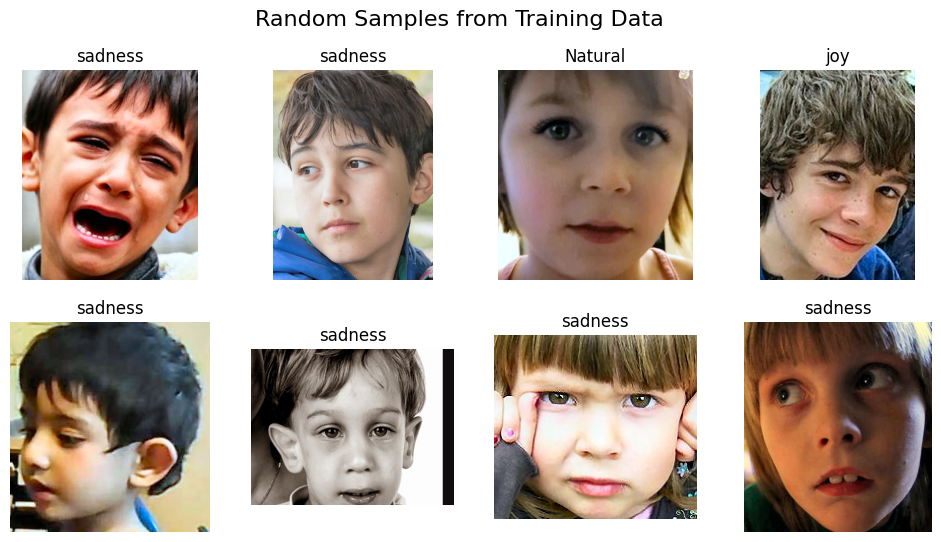

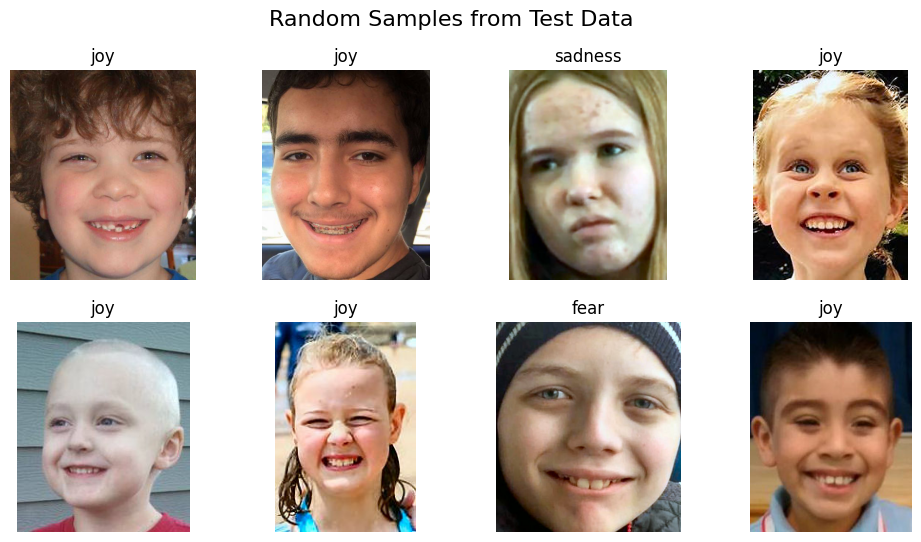

In [ ]:
import cv2
import random
# Function to display random sample images along with their labels
def display_samples(df, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    # Randomly pick 8 samples
    random_samples = df.sample(n=8).reset_index(drop=True)

    for index, row in random_samples.iterrows():
        plt.subplot(2, 4, index + 1)

        # Read the image
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(row['label'])
        plt.axis('off')

    plt.show()

# Display random samples from training and test datasets
display_samples(train_df, "Random Samples from Training Data")
display_samples(test_df, "Random Samples from Test Data")

## Section 3: Creating, training, and evaluating CNNS
<a id='section3'></a>

### CNN from Scratch

In [ ]:
# create a simple CNN
scratch_model = Sequential([Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)),
                           MaxPooling2D(),
                           Conv2D(32, 3, strides=2, activation='relu'),
                           MaxPooling2D(),
                           Conv2D(64, 3, strides=2, activation='relu'),
                           MaxPooling2D(),
                           Conv2D(128, 3, strides=2, activation='relu'),
                           MaxPooling2D(),
                           Flatten(),
                           Dense(256, activation='relu'),
                           Dense(128, activation='relu'),
                           Dense(64, activation='relu'),
                           Dense(6, activation='softmax')
                           ])
scratch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0

In [ ]:
# compile the model
scratch_model.compile(optimizer='adam', loss='categorical_crossentropy',
                    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
# callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=25,
    restore_best_weights=True
)
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    verbose=1,
    mode='min'
)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001
)
callbacks = [early_stop, save_best_model, reduce_lr_on_plateau]


In [ ]:
# train the model
epochs = 50
scratch_history = scratch_model.fit(train_generator,epochs = epochs, validation_data = test_generator, callbacks = callbacks)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.5157 - accuracy: 0.4406 - precision: 0.3675 - recall: 0.0567
Epoch 1: val_loss improved from inf to 1.38490, saving model to ./best_weights.h5
24/24 [==============================] - 42s 1s/step - loss: 1.5157 - accuracy: 0.4406 - precision: 0.3675 - recall: 0.0567 - val_loss: 1.3849 - val_accuracy: 0.5600 - val_precision: 0.4286 - val_recall: 0.1600 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.4410 - accuracy: 0.4617 - precision: 0.4874 - recall: 0.1280
Epoch 2: val_loss did not improve from 1.38490
24/24 [==============================] - 10s 407ms/step - loss: 1.4410 - accuracy: 0.4617 - precision: 0.4874 - recall: 0.1280 - val_loss: 1.4176 - val_accuracy: 0.5600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 1.4536 - accuracy: 0.4617 - precision: 0.4464 - recall: 0.0660
Epoch 3: val_loss d

In [ ]:
# save history object into a file
with open('./scratch_trainhistory', 'wb') as pkl:
    pickle.dump(scratch_history.history, pkl)

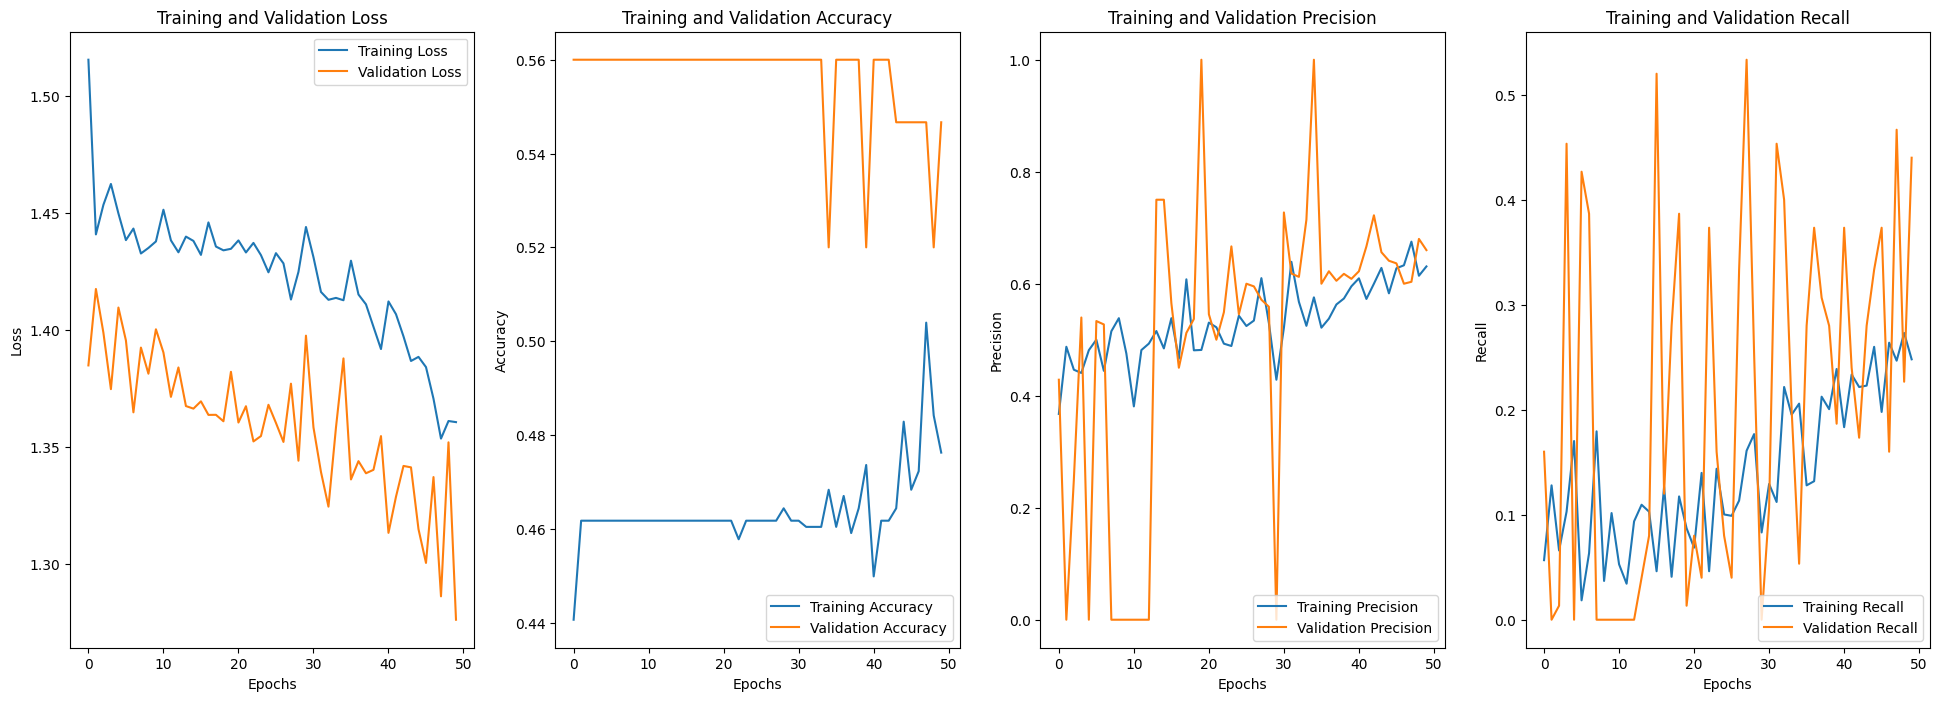

In [ ]:
# plot the loss, accuracy, precision, and recall values achieved during training for the training and validation set.
training_loss = scratch_history.history['loss']
validation_loss = scratch_history.history['val_loss']

training_accuracy = scratch_history.history['accuracy']
validation_accuracy = scratch_history.history['val_accuracy']

training_precision = scratch_history.history['precision']
validation_precision = scratch_history.history['val_precision']

training_recall = scratch_history.history['recall']
validation_recall = scratch_history.history['val_recall']

epochs_range = range(epochs)


plt.figure(figsize=(24, 8))


plt.subplot(1, 4, 1)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')


plt.subplot(1, 4, 2)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')


plt.subplot(1, 4, 3)
plt.plot(epochs_range, training_precision, label= 'Training Precision')
plt.plot(epochs_range, validation_precision, label='Validation Precision')
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title('Training and Validation Precision')


plt.subplot(1, 4, 4)
plt.plot(epochs_range, training_recall, label= 'Training Recall')
plt.plot(epochs_range, validation_recall, label='Validation Recall')
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title('Training and Validation Recall');

In [ ]:
# save training and validation metrics
best_model_idx = scratch_history.history['val_loss'].index(min(scratch_history.history['val_loss']))
train_loss = scratch_history.history['loss'][best_model_idx]
val_loss   = scratch_history.history['val_loss'][best_model_idx]
train_acc  = scratch_history.history['accuracy'][best_model_idx]*100
val_acc    = scratch_history.history['val_accuracy'][best_model_idx]*100
train_precision = scratch_history.history['precision'][best_model_idx]*100
val_precision = scratch_history.history['val_precision'][best_model_idx]*100
train_recall = scratch_history.history['recall'][best_model_idx]*100
val_recall = scratch_history.history['val_recall'][best_model_idx]*100

In [ ]:
# print training and validation metrics
print("Training loss of the best basic model: ", train_loss)
print("Validation loss of the best basic model: ", val_loss)
print("Training accuracy of the best basic model: ", train_acc,"%")
print("Validation accuracy of the best basic model: ", val_acc,"%")
print("Training precision of the best basic model: ", train_precision,"%")
print("Validation precision of the best basic model: ", val_precision,"%")
print("training recall of the best basic model: ", train_recall,"%")
print("Validation recall of the best basic model: ", val_recall,"%")

Training loss of the best basic model:  1.3606308698654175
Validation loss of the best basic model:  1.2760952711105347
Training accuracy of the best basic model:  47.625330090522766 %
Validation accuracy of the best basic model:  54.666668176651 %
Training precision of the best basic model:  63.08724880218506 %
Validation precision of the best basic model:  66.00000262260437 %
training recall of the best basic model:  24.802111089229584 %
Validation recall of the best basic model:  43.99999976158142 %


### Transfer Learning CNN

In [ ]:
model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=(224,224,3))
model.trainable = True
tl_model = tf.keras.Sequential([
        model,
        GlobalAveragePooling2D(),
        Dense(6, activation='softmax')])

tl_model.summary()

# Compile the model
tl_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 4015234 (15.32 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [ ]:
# compile the model
tl_model.compile(optimizer='adam', loss='categorical_crossentropy',
                    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
# callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=25,
    restore_best_weights=True
)
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_weights_B0.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    verbose=1,
    mode='min'
)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001
)
callbacks = [early_stop, save_best_model, reduce_lr_on_plateau]

In [ ]:
# Train the model
epochs = 50
history = tl_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.3193 - accuracy: 0.5079 - precision_2: 0.7335 - recall_2: 0.3377
Epoch 1: val_loss improved from inf to 2.14266, saving model to ./best_weights_B0.h5
24/24 [==============================] - 54s 667ms/step - loss: 1.3193 - accuracy: 0.5079 - precision_2: 0.7335 - recall_2: 0.3377 - val_loss: 2.1427 - val_accuracy: 0.1867 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.9560 - accuracy: 0.6583 - precision_2: 0.7676 - recall_2: 0.5185
Epoch 2: val_loss improved from 2.14266 to 1.99464, saving model to ./best_weights_B0.h5
24/24 [==============================] - 14s 572ms/step - loss: 0.9560 - accuracy: 0.6583 - precision_2: 0.7676 - recall_2: 0.5185 - val_loss: 1.9946 - val_accuracy: 0.0933 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.

In [ ]:
# save history object into a file
with open('./tl_trainhistory', 'wb') as pkl:
    pickle.dump(history.history, pkl)

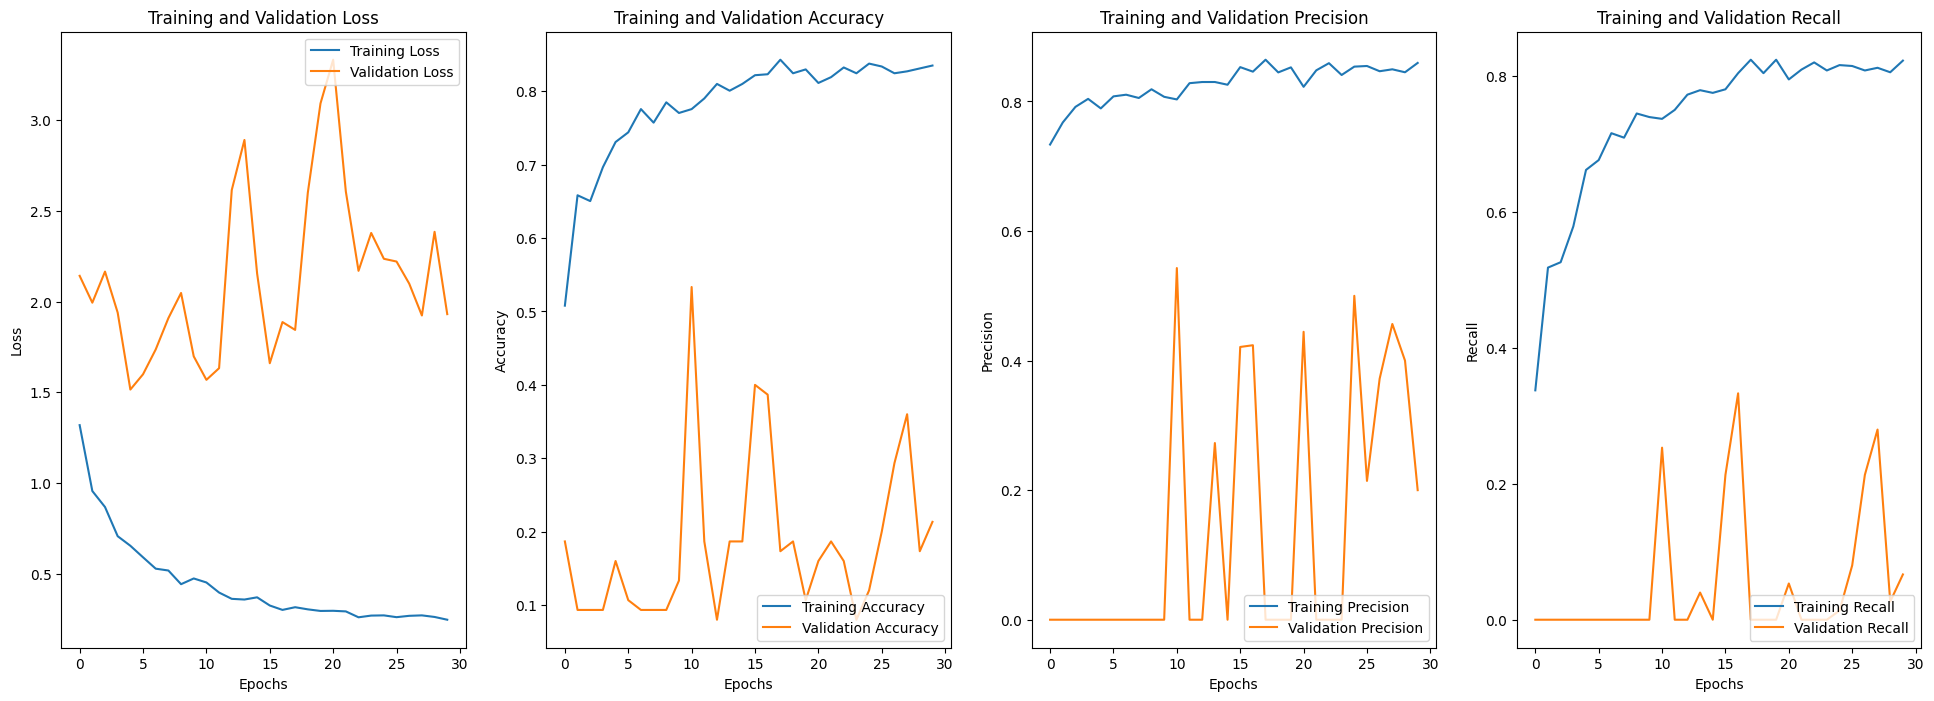

In [ ]:
# plot the loss, accuracy, precision, and recall values achieved during training for the training and validation set.
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_precision = history.history['precision_2']
validation_precision = history.history['val_precision_2']

training_recall = history.history['recall_2']
validation_recall = history.history['val_recall_2']

epochs_range = range(len(history.history['accuracy']))


plt.figure(figsize=(24, 8))


plt.subplot(1, 4, 1)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')


plt.subplot(1, 4, 2)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')


plt.subplot(1, 4, 3)
plt.plot(epochs_range, training_precision, label= 'Training Precision')
plt.plot(epochs_range, validation_precision, label='Validation Precision')
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title('Training and Validation Precision')


plt.subplot(1, 4, 4)
plt.plot(epochs_range, training_recall, label= 'Training Recall')
plt.plot(epochs_range, validation_recall, label='Validation Recall')
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title('Training and Validation Recall');

In [ ]:
# save training and validation metrics
best_model_idx = history.history['val_loss'].index(min(history.history['val_loss']))
train_loss = history.history['loss'][best_model_idx]
val_loss   = history.history['val_loss'][best_model_idx]
train_acc  = history.history['accuracy'][best_model_idx]*100
val_acc    = history.history['val_accuracy'][best_model_idx]*100
train_precision = history.history['precision_2'][best_model_idx]*100
val_precision = history.history['val_precision_2'][best_model_idx]*100
train_recall = history.history['recall_2'][best_model_idx]*100
val_recall = history.history['val_recall_2'][best_model_idx]*100

In [ ]:
# print training and validation metrics
print("Training loss of the best transfer learning model: ", train_loss)
print("Validation loss of the best transfer learning model: ", val_loss)
print("Training accuracy of the best transfer learning model: ", train_acc,"%")
print("Validation accuracy of the best transfer learning model: ", val_acc,"%")
print("Training precision of the best transfer learning model: ", train_precision,"%")
print("Validation precision of the best transfer learning model: ", val_precision,"%")
print("training recall of the best transfer learning  model: ", train_recall,"%")
print("Validation recall of the best transfer learning model: ", val_recall,"%")

Training loss of the best transfer learning model:  0.6541126370429993
Validation loss of the best transfer learning model:  1.5155971050262451
Training accuracy of the best transfer learning model:  73.08707237243652 %
Validation accuracy of the best transfer learning model:  15.999999642372131 %
Training precision of the best transfer learning model:  78.93081903457642 %
Validation precision of the best transfer learning model:  0.0 %
training recall of the best transfer learning  model:  66.2269115447998 %
Validation recall of the best transfer learning model:  0.0 %


In [ ]:
from google.colab import files
files.download('best_weights_B0.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Function to load and process images
def process_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))  # Resize images
    return image.flatten()  # Flatten the image

# Apply the function to each image in the DataFrame
train_features = np.array([process_image(path) for path in train_df['image_path']])
test_features = np.array([process_image(path) for path in test_df['image_path']])

# Encode labels to numeric values
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_labels = train_df['label'].map(label_mapping)
test_labels = test_df['label'].map(label_mapping)

# Handle imbalance in the dataset
smote = SMOTE()
train_features_balanced, train_labels_balanced = smote.fit_resample(train_features, train_labels)

# Splitting the training data for validation
X_train, X_val, y_train, y_val = train_test_split(train_features_balanced, train_labels_balanced, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
val_predictions = model.predict(X_val)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print("Classification Report:\n", classification_report(y_val, val_predictions))

# Predict on the test set
test_predictions = model.predict(test_features)
print("Test Accuracy:", accuracy_score(test_labels, test_predictions))
print("Test Classification Report:\n", classification_report(test_labels, test_predictions))


Validation Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.60      0.59        63
           1       0.27      0.29      0.28        69
           2       0.80      0.71      0.75        84
           3       0.78      0.75      0.77        77
           4       0.84      0.88      0.86        66
           5       0.64      0.64      0.64        61

    accuracy                           0.65       420
   macro avg       0.65      0.65      0.65       420
weighted avg       0.66      0.65      0.65       420

Test Accuracy: 0.4533333333333333
Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.29      0.24        14
           2       0.68      0.64      0.66        42
           3       0.00      0.00      0.00         3
           4       0.50      0.29      0.36         7
           5       